# Pràctica 1: Identificació d'Idioma
**Assignatura:** Processament del Llenguatge Humà (PLH)  
**Model:** Model de llenguatge basat en n-grames de caràcters 

## 1. Introducció
L'objectiu d'aquesta pràctica és construir un classificador automàtic capaç d'assignar un idioma $l_i$ a un document $d$ d'entre un conjunt de 6 llengües europees: alemany (deu), anglès (eng), francès (fra), italià (ita), neerlandès (nld) i castellà (spa).

El sistema es basa en la hipòtesi que les freqüències de certes seqüències de lletres (n-grames) són úniques per a cada idioma. En aquest cas, utilitzarem **trigrammes de caràcters** (n=3).

### Recursos
**Entrenament (Training):** 30.000 frases per idioma del corpus Wortschatz Leipzig.

**Validació (Test):** 10.000 frases per idioma per avaluar la precisió (accuracy) i generar la matriu de confusió.



In [1]:
import re
import os
import math
import pandas as pd
import nltk
from nltk.collocations import TrigramCollocationFinder
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

## 2. Pas 1: Preprocessament del Text
El text brut ha de ser normalitzat abans de l'entrenament per evitar biaixos causats per elements no lingüístics. 

### Procediment de neteja:
1. **Eliminar els dígits**: S'eliminen els números del text, ja que no són informatius per identificar l'idioma.
2. **Convertir a minúscula**: Es normalitzen tots els caràcters per reduir la dispersió de dades.
3. **Substitució d'espais**: Es canvien els espais en blanc continus (o tabulacions) per un sol espai.
4. **Unió de frases**: Es concatenen totes les frases del corpus inserint un **espai doble** entre elles.

### eliminacio dels signes de puntuacio

Signes distintius a CONSERVAR (Informació clau)

Aquests signes no s'han de tocar perquè formen part de la identitat morfològica de l'idioma i aporten "punts" directes a un model de trigrames:

- ¡ i ¿ (Signes d'obertura): Com molt ben dius, són exclusius del castellà en aquest grup de llengües. Un trigrama com (' ', '¿', 'q') pràcticament garanteix que la frase és en castellà.

- ' (Apòstrof recte o corb): És vital.

    - En francès i italià indica elisió d'articles i pronoms (c'est, l'albero, qu'il).

    - En anglès indica contraccions i genitiu saxó (don't, John's).

    - En neerlandès s'usa per a plurals i possessius (auto's, 's-morgens).

In [ ]:
class LanguagePreprocessor:
    def __init__(self, idiomes, eliminar_puntuacio=False):
        self.idiomes = idiomes
        self.eliminar_puntuacio = eliminar_puntuacio
        
    def clean_text(self, frases):
        neteja = []
        for linia in frases:
            text = re.sub(r'\d+', '', linia)

            if self.eliminar_puntuacio:
                text = re.sub(r'[^\w\s\'’¡¿]', ' ', text) # elimina tots els signes de puntuacio excepte '’¡¿' 

            text = text.lower()
            text = re.sub(r'\s+', ' ', text).strip()
            
            if text:
                neteja.append(text)

        return "  " + "  ".join(neteja) + "  "

    def process_files(self, tipus_fitxers=['trn', 'tst'], sufix=""):
        for idioma in self.idiomes:
            for tipus in tipus_fitxers:
                nom_fitxer = f"{idioma}_{tipus}.txt"
                if os.path.exists(nom_fitxer):
                    with open(nom_fitxer, 'r', encoding='utf-8') as f:
                        linies = f.readlines()
                    text_net = self.clean_text(linies)
                    
                    nom_sortida = f"{idioma}_{tipus}_clean{sufix}.txt" 
                    with open(nom_sortida, 'w', encoding='utf-8') as f_out:
                        f_out.write(text_net)
                    print(f"Desat: {nom_sortida}")

    def obtenir_frases_netes(self, fitxer):
        with open(fitxer, 'r', encoding='utf-8') as f:
            text = f.read()
        return [frase for frase in text.split("  ") if len(frase.strip()) > 0]

# Execució del preprocessament 
idiomes = ['deu', 'eng', 'fra', 'ita', 'nld', 'spa'] 
preprocessor = LanguagePreprocessor(idiomes, eliminar_puntuacio=False)
preprocessor.process_files()

Processant deu_trn.txt...
Desat: deu_trn_clean.txt
Processant deu_tst.txt...
Desat: deu_tst_clean.txt
Processant eng_trn.txt...
Desat: eng_trn_clean.txt
Processant eng_tst.txt...
Desat: eng_tst_clean.txt
Processant fra_trn.txt...
Desat: fra_trn_clean.txt
Processant fra_tst.txt...
Desat: fra_tst_clean.txt
Processant ita_trn.txt...
Desat: ita_trn_clean.txt
Processant ita_tst.txt...
Desat: ita_tst_clean.txt
Processant nld_trn.txt...
Desat: nld_trn_clean.txt
Processant nld_tst.txt...
Desat: nld_tst_clean.txt
Processant spa_trn.txt...
Desat: spa_trn_clean.txt
Processant spa_tst.txt...
Desat: spa_tst_clean.txt


## 3. Pas 2: Generació del Model i Filtratge amb NLTK

Per a la construcció del model de llenguatge basat en caràcters, utilitzarem la llibreria **NLTK**, concretament la classe `TrigramCollocationFinder`.

### Procediment:
1. **Extracció de Trigrammes de caràcters:** Com que volem un model basat en caràcters, passarem l'string sencer (el text prèviament netejat) a la funció `from_words()`. D'aquesta manera, NLTK tractarà cada lletra i espai com una unitat bàsica, generant seqüències de 3 caràcters (ex: `('c', 'a', 's')`).
2. **Filtratge de freqüències:** Per reduir el soroll estadístic i eliminar combinacions rares o errors, eliminem els trigrammes que apareguin menys de 5 vegades al corpus. Utilitzarem la funció nativa d'NLTK `apply_freq_filter(5)`.
3. **Obtenció del diccionari:** Finalment, extreurem les freqüències filtrades mitjançant l'atribut `ngram_fd`, que ens retorna un diccionari de freqüències (FreqDist) llest per ser utilitzat en el càlcul de probabilitats.

In [ ]:
class LanguageModel:
    def __init__(self, idiomes):
        self.idiomes = idiomes
        self.models_uni = {}
        self.models_bi = {}
        self.models_tri = {}
        self.N_uni = {}
        self.N_bi = {}
        self.N_tri = {}
        self.recomptes = {}
        self.vocabulari_global = set()
        self.B_global = 0

    def train(self, data_dict):
        """
        data_dict: dict amb format {idioma: string_amb_tot_el_text}
        """
        self.vocabulari_global = set()
        
        for idioma in self.idiomes:
            text_train = data_dict[idioma]
            
            # Models d'unigrames i bigrames
            llista_chars = list(text_train)
            self.models_uni[idioma] = nltk.FreqDist(llista_chars)
            self.models_bi[idioma] = nltk.FreqDist(nltk.ngrams(llista_chars, 2))
            
            self.N_uni[idioma] = len(llista_chars)
            self.N_bi[idioma] = len(llista_chars) - 1
            
            # Model principal de trigrames
            finder = TrigramCollocationFinder.from_words(text_train)
            
            # Afegim tots els trigrames trobats al vocabulari global abans de filtrar
            for trigramma in finder.ngram_fd.keys():
                self.vocabulari_global.add(trigramma)
                
            # Apliquem el filtre de freqüència >= 5 
            finder.apply_freq_filter(5)
            model = finder.ngram_fd
            
            self.models_tri[idioma] = model
            self.N_tri[idioma] = sum(model.values()) 
            self.recomptes[idioma] = len(model) 

        # Càlcul de B global
        self.B_global = len(self.vocabulari_global)

    def _get_trigram_fd(self, frase):
        finder = TrigramCollocationFinder.from_words("  " + frase + "  ")
        return finder.ngram_fd

    def calcul_probabilitat(self, frase, idioma, parametre, tecnica):
        # Generem els trigrames de la frase
        trigrames_frase = self._get_trigram_fd(frase)
        
        model3 = self.models_tri[idioma]
        N = self.N_tri[idioma] 
        V = self.recomptes[idioma] 
        
        log_p = 0.0
        
        for trig, freq in trigrames_frase.items():
            c3 = model3.get(trig, 0)
            
            if tecnica == 'lidstone':
                lamb = parametre
                p = (c3 + lamb) / (N + self.B_global * lamb)
                
            elif tecnica == 'absolute_discounting':
                delta = parametre
                N0 = self.B_global - V 
                if c3 > 0:
                    p = (c3 - delta) / N
                else:
                    p = ((self.B_global - N0) * delta / N0) / N
                    
            elif tecnica == 'interpolation':
                lamb3, lamb2, lamb1 = parametre 
                w_n_2, w_n_1, w_n = trig

                c2 = self.models_bi[idioma].get((w_n_2, w_n_1), 0)
                p3 = c3 / c2 if c2 > 0 else 0
                
                c_bigrama = self.models_bi[idioma].get((w_n_1, w_n), 0)
                c1 = self.models_uni[idioma].get(w_n_1, 0)
                p2 = c_bigrama / c1 if c1 > 0 else 0
                
                c_unigrama = self.models_uni[idioma].get(w_n, 0)
                p1 = c_unigrama / self.N_uni[idioma] if self.N_uni[idioma] > 0 else 0
                
                p = lamb1 * p1 + lamb2 * p2 + lamb3 * p3
                
            if p <= 0: 
                p = 1e-10 
                
            log_p += freq * math.log(p)
            
        return log_p

Model per 'deu' generat amb èxit. Trigrammes únics: 11321
Model per 'eng' generat amb èxit. Trigrammes únics: 9390
Model per 'fra' generat amb èxit. Trigrammes únics: 10421
Model per 'ita' generat amb èxit. Trigrammes únics: 8325
Model per 'nld' generat amb èxit. Trigrammes únics: 10148
Model per 'spa' generat amb èxit. Trigrammes únics: 9294

Tots els models d'entrenament han estat generats.


## 4. Pas 3: Càlcul de Probabilitats i Tècniques de Suavitzat (Smoothing)

Per calcular la probabilitat que un document de text pertanyi a un idioma determinat, utilitzem un model basat en n-grames assumint independència condicional (enfocament *Naive Bayes*). La probabilitat del document sencer s'estima com el producte de les probabilitats individuals de cada trigramma que el compon.

El problema d'utilitzar l'estimació de Màxima Versemblança (MLE) és la dispersió de dades: assigna una probabilitat de zero als trigrammes no observats durant l'entrenament, la qual cosa anul·la automàticament la probabilitat de tota la frase. Per evitar-ho, utilitzarem i compararem **tres tècniques de suavitzat (smoothing)**.

### 4.1. L'espai mostral i l'estimació de $B$

Abans d'aplicar qualsevol fórmula, cal definir acuradament l'espai mostral. Totes les tècniques necessitaran el paràmetre **$B$**, que representa la mida del vocabulari, és a dir, el nombre de trigrammes *potencialment observables*.

**Per què $B$ ha de ser global i igual per a tots els idiomes?**
Si volem comparar de forma justa $P(text | anglès)$ i $P(text | francès)$ mitjançant un `argmax`, ambdós models han de basar-se en el mateix espai mostral. Si cada idioma tingués la seva pròpia $B$, les probabilitats estarien distribuïdes sobre espais de diferent mida i no serien matemàticament comparables.

**Com estimem $B$?**
Teòricament, $B$ podria ser totes les combinacions matemàtiques possibles de 3 caràcters (ex: $30^3 = 27.000$), però moltes d'aquestes combinacions no existeixen en cap idioma humà. D'altra banda, si calculem $B$ només amb els trigrammes filtrats (freq $\ge 5$), estaríem subestimant la diversitat real de la llengua. 
Per tant, la millor estimació és la **unió de tots els trigrammes únics trobats en els corpus d'entrenament de tots els idiomes ABANS d'aplicar el filtre**. Això ens dona una constant $B$ global, realista i robusta per a totes les fórmules.

---

### 4.2. Les Tres Tècniques de Suavitzat

En tots els models definirem **$N_T$** com la suma total de les freqüències dels trigrammes de l'idioma (després del filtre) i **$c_T(e_j)$** com la freqüència d'un trigramma específic.

#### A) Llei de Lidstone
Aquesta tècnica afegeix una petita quantitat constant $\lambda$ a totes les observacions (vistes i no vistes) per evitar els zeros.

$$P_{LID}(e_j) = \frac{c_T(e_j) + \lambda}{N_T + \lambda \cdot B}$$

El paràmetre $\lambda$ controla quanta "massa de probabilitat" traiem als trigrammes observats per repartir-la entre els desconeguts.

#### B) Descompte Absolut (Absolute Discounting)
En comptes d'afegir probabilitat a tot arreu, aquesta tècnica **resta una quantitat constant $\alpha$** ($0 < \alpha < 1$) a les freqüències dels trigrammes que sí que hem observat. La massa de probabilitat total "robada" és $\alpha \cdot V_T$ (on $V_T$ és el nombre de trigrammes únics de l'idioma). Aquesta massa es reparteix uniformement **només entre els trigrammes que no hem vist mai** (que són exactament $B - V_T$).

* **Si el trigramma s'ha vist ($c_T(e_j) > 0$):**
  $$P_{AD}(e_j) = \frac{c_T(e_j) - \alpha}{N_T}$$

* **Si el trigramma NO s'ha vist ($c_T(e_j) = 0$):**
  $$P_{AD}(e_j) = \frac{\frac{V_T \cdot \alpha}{B - V_T}}{N_T}$$

#### C) Interpolació Lineal (Jelinek-Mercer)
Aquesta tècnica construeix un model més robust combinant (interpolant) la probabilitat del trigrama amb les probabilitats d'ordre inferior (bigrames i unigrames). Si un trigrama no s'ha vist mai, el model es recolza en contextos més curts per no anul·lar la probabilitat.

Donat un trigrama $e_j = (w_{i-2}, w_{i-1}, w_i)$:

$$P_{INT}(d) \approx \lambda_0 \cdot P(w_i, w_{i-1}, w_{i-2}) + \lambda_1 \cdot P(w_i, w_{i-1}) + \lambda_2 \cdot P(w_i)$$

Amb la condició estricta que $\lambda_0 + \lambda_1 + \lambda_2 = 1$. Els paràmetres $\lambda$ indiquen el "pes" que atorguem a cada nivell d'informació (trigrama, bigrama i unigrama respectivament).

---

### 4.3. Selecció del Model via Validació Creuada (Cross-Validation)

Assumir paràmetres a cegues no és rigorós. Per trobar la millor tècnica i el seu hiperparàmetre òptim, implementarem un procés de *Cross-Validation*:

1. **Partició de dades:** Dividirem el corpus d'entrenament mitjançant *Hold-out Validation* (80% per entrenar, 20% per validar).
2. **Entrenament:** Construirem els models de freqüències utilitzant exclusivament el 80% de les dades.
3. **Avaluació (Grid Search):** Avaluarem l'exactitud (*accuracy*) en el 20% de validació provant les 3 tècniques amb diferents bateries de valors per als seus paràmetres ($\lambda$ per Lidstone, $\alpha$ per Descompte Absolut i conjunts de tuples $\lambda_n$ per Interpolació).
4. **Selecció Final:** Ens quedarem amb el mètode i el paràmetre que assoleixi el millor percentatge d'encerts globals per utilitzar-lo, posteriorment, amb les dades de Test.

## 4. Pas 3: Càlcul de Probabilitats i Tècniques de Suavitzat (Smoothing)

Per calcular la probabilitat que un document de text pertanyi a un idioma determinat, utilitzem un model basat en n-grames assumint independència condicional (enfocament *Naive Bayes*). Com que treballem amb probabilitats molt petites, calculem la **log-probabilitat** sumant els logaritmes de cada n-grama per evitar el subdesbordament aritmètic (*underflow*) de l'ordinador.

El problema d'utilitzar l'estimació de Màxima Versemblança (MLE) és la dispersió de dades: assigna una probabilitat de zero als trigrammes no observats durant l'entrenament, la qual cosa anul·la automàticament la probabilitat de tota la frase. Per evitar-ho, utilitzarem i compararem **tres tècniques de suavitzat (smoothing)**.

### 4.1. L'espai mostral i l'estimació de $B$

Abans d'aplicar qualsevol fórmula, cal definir acuradament l'espai mostral. Totes les tècniques necessitaran el paràmetre **$B$**, que representa el nombre de valors potencialment observables per a l'n-grama.

**Per què $B$ ha de ser global i igual per a tots els idiomes?**
Si volem comparar de forma justa $P(text | anglès)$ i $P(text | francès)$ mitjançant un `argmax`, ambdós models han de basar-se en el mateix espai mostral. Si cada idioma tingués la seva pròpia $B$, les probabilitats estarien distribuïdes sobre espais de diferent mida i no serien matemàticament comparables.

**Com estimem $B$?**
Teòricament, $B$ podria ser totes les combinacions matemàtiques possibles de 3 caràcters. No obstant això, la millor estimació és la **unió de tots els trigrammes únics trobats en els corpus d'entrenament de tots els idiomes ABANS d'aplicar el filtre**. Això ens dona una constant $B$ global, realista i robusta.

---

### 4.2. Consideracions sobre els denominadors ($N$)

S'ha optat per una **metodologia asimètrica** en el càlcul del nombre total d'observacions ($N$) segons el nivell del model:

* **Models d'unigrames i bigrames:** En aquests nivells, $N_{uni}$ i $N_{bi}$ representen la totalitat dels caràcters del corpus d'entrenament. No s'aplica cap filtre per garantir que la "xarxa de seguretat" de la interpolació estigui completa.
* **Model de trigrames ($N_{tri}$):** Es calcula com la suma de les freqüències **posteriors al filtratge** ($\ge 5$). Això assegura que la probabilitat es reparteixi exclusivament entre esdeveniments significatius, evitant diluir-la cap a combinacions descartades per soroll.

---

### 4.3. Les Tres Tècniques de Suavitzat

En les següents fórmules, $C(w_{1}...w_{n})$ representa la freqüència d'un n-grama específic en el model d'entrenament.

#### A) Llei de Lidstone
[cite_start]Aquesta tècnica afegeix una quantitat constant $\lambda$ (on $\lambda < 1$) als recomptes de totes les observacions[cite: 13]. Això roba una mica de "massa de probabilitat" als trigrammes observats per repartir-la entre els desconeguts.

[cite_start]$$P_{LID}(w_1...w_n) = \frac{C(w_1...w_n) + \lambda}{N_{tri} + B \lambda}$$ [cite: 19]

#### B) Descompte Absolut (Absolute Discounting)
[cite_start]En comptes d'afegir probabilitat a tot arreu, aquesta tècnica **resta una quantitat constant $\delta$** ($0 < \delta < 1$) a les freqüències dels trigrammes que sí que hem observat[cite: 35]. Aquesta massa es reparteix uniformement **només entre els trigrammes que no hem vist mai**.

[cite_start]Per a aquesta fórmula definim $N_0$ com el nombre de possibles valors observats 0 vegades[cite: 40]. A la pràctica, es calcula com $N_0 = B - V$, on $V$ són els trigrammes únics vistos en l'idioma.

* **Si el trigramma s'ha vist ($C(w_1...w_n) > 0$):**
  [cite_start]$$P_{ABS}(w_1...w_n) = \frac{C(w_1...w_n) - \delta}{N_{tri}}$$ [cite: 41]

* **Si el trigramma NO s'ha vist (altrament):**
  [cite_start]$$P_{ABS}(w_1...w_n) = \frac{(B - N_0)\delta / N_0}{N_{tri}}$$ [cite: 41]

#### C) Interpolació Lineal
Aquesta tècnica construeix un model més robust combinant (interpolant) la probabilitat condicionada del trigrama amb les probabilitats condicionades d'ordre inferior (bigrames i unigrames). Si un trigrama no s'ha vist mai en un context determinat, el model es recolza en la probabilitat del caràcter en contextos més curts per evitar anul·lar la probabilitat final.

La fórmula de la combinació lineal per a un trigrama compost pels caràcters $(w_{n-2}, w_{n-1}, w_n)$ és:

$$P_{LI}(w_n | w_{n-2}, w_{n-1}) = \lambda_3 \cdot P_3(w_n | w_{n-2}, w_{n-1}) + \lambda_2 \cdot P_2(w_n | w_{n-1}) + \lambda_1 \cdot P_1(w_n)$$

On cada probabilitat s'estima mitjançant Màxima Versemblança (MLE) dividint la freqüència de l'n-grama per la freqüència del seu context històric (excepte en l'unigrama, que es divideix pel total de caràcters):

* **Trigrama:** $P_3(w_n | w_{n-2}, w_{n-1}) = \frac{C(w_{n-2}, w_{n-1}, w_n)}{C(w_{n-2}, w_{n-1})}$
* **Bigrama:** $P_2(w_n | w_{n-1}) = \frac{C(w_{n-1}, w_n)}{C(w_{n-1})}$
* **Unigrama:** $P_1(w_n) = \frac{C(w_n)}{N_{uni}}$

Tot això sota la condició estricta que $\lambda_3 + \lambda_2 + \lambda_1 = 1$. Els paràmetres $\lambda$ indiquen el "pes" relatiu que atorguem a cada nivell d'informació.

---

### 4.4. Selecció del Model via Validació Creuada (Cross-Validation)

Assumir paràmetres a cegues no és rigorós. Per trobar la millor tècnica i el seu hiperparàmetre òptim, implementarem un procés de *Cross-Validation*:

1. **Partició de dades:** Dividirem el corpus d'entrenament mitjançant *Hold-out Validation* (80% per entrenar, 20% per validar).
2. **Entrenament:** Construirem els models de freqüències utilitzant exclusivament el 80% de les dades.
3. **Avaluació:** Avaluarem l'exactitud (*accuracy*) en el 20% de validació provant les 3 tècniques amb diferents bateries de valors per als seus paràmetres ($\lambda$ per Lidstone, $\delta$ per Descompte Absolut i conjunts de tuples $\lambda_n$ per Interpolació).
4. **Selecció Final:** Ens quedarem amb el mètode i el paràmetre que assoleixi el millor percentatge d'encerts globals per utilitzar-lo, posteriorment, amb les dades de Test.

### Consideracions sobre els denominadors ($N$)

S'ha optat per una metodologia asimètrica en el càlcul del nombre total de mostres ($N$) segons el nivell del model. Per als models d'unigrames i bigrames, $N$ representa la totalitat dels caràcters del corpus, garantint que la xarxa de seguretat de la interpolació sigui completa. 

En canvi, per al model de trigrames, $N_{tri}$ es calcula com la suma de les freqüències **posteriors al filtratge** ($\ge 5$). Aquesta decisió assegura que la distribució de probabilitat es reparteixi exclusivament entre els esdeveniments que el model considera significatius, evitant una dilució artificial de la probabilitat cap a combinacions que han estat descartades per soroll.

In [ ]:
class LanguageEvaluator:
    def __init__(self, model):
        self.model = model

    def predict(self, frase, tecnica, parametre):
        max_prob = -float('inf')
        idioma_predit = None
        
        for idioma_model in self.model.idiomes:
            prob = self.model.calcul_probabilitat(frase, idioma_model, parametre, tecnica)
            if prob > max_prob:
                max_prob = prob
                idioma_predit = idioma_model
                
        return idioma_predit

    def cross_validation(self, dades_val, proves):
        resultats_cv = {}
        
        for tecnica, llista_parametres in proves.items():
            print(f"--- Avaluant tècnica: {tecnica.upper()} ---")
            millor_acc_tecnica = 0.0
            millor_param_tecnica = None
            
            for param in llista_parametres:
                encerts = 0
                total_frases = 0
                
                for idioma_real, llista_frases in dades_val.items():
                    for frase in llista_frases:
                        total_frases += 1
                        idioma_predit = self.predict(frase, tecnica, param)
                        
                        if idioma_predit == idioma_real:
                            encerts += 1
                            
                accuracy = encerts / total_frases
                print(f"  Param={str(param):<15} -> Accuracy: {accuracy:.4f}")
                
                if accuracy > millor_acc_tecnica:
                    millor_acc_tecnica = accuracy
                    millor_param_tecnica = param
                    
            resultats_cv[tecnica] = {'param': millor_param_tecnica, 'acc': millor_acc_tecnica}
            print(f"  >> Guanyador {tecnica}: Param={millor_param_tecnica} (Acc={millor_acc_tecnica:.4f})\n")
            
        millor_tecnica_global = None
        millor_acc_global = 0.0

        for tec, res in resultats_cv.items():
            if res['acc'] > millor_acc_global:
                millor_acc_global = res['acc']
                millor_tecnica_global = tec

        print(f"\nLa millor tècnica és: {millor_tecnica_global.upper()} amb un accuracy de {millor_acc_global:.4f}")
        return resultats_cv, millor_tecnica_global, millor_acc_global

    def avaluar_test(self, dades_test, tecnica, parametre):
        y_true = []
        y_pred = []
        
        for idioma_real, frases in dades_test.items():
            for frase in frases:
                y_true.append(idioma_real)
                idioma_predit = self.predict(frase, tecnica, parametre)
                y_pred.append(idioma_predit)
                
        acc_final = accuracy_score(y_true, y_pred)
        print(f"\nResultat Final")
        print(f"Accuracy en Test: {acc_final:.4f} ({int(acc_final * len(y_true))}/{len(y_true)} encerts)")
        
        cm = confusion_matrix(y_true, y_pred, labels=self.model.idiomes)
        df_cm = pd.DataFrame(cm, index=self.model.idiomes, columns=self.model.idiomes)
        
        plt.figure(figsize=(8, 6))
        sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.title(f'Matriu de Confusió ({tecnica} {str(parametre)}) - Acc: {acc_final:.4f}')
        plt.ylabel('Idioma Real')
        plt.xlabel('Idioma Predit')
        plt.show()
        
        print("\nMatriu de Confusió (Text):")
        print(df_cm)
        return y_true, y_pred, df_cm


# PARTICIÓ DE DADES PER A CROSS-VALIDATION
dades_train_cv = {}
dades_val_cv = {}

for idioma in idiomes:
    fitxer_train = f"{idioma}_trn_clean.txt"
    if os.path.exists(fitxer_train):
        frases = preprocessor.obtenir_frases_netes(fitxer_train)
        divisio = int(len(frases) * 0.8)
        text_train = "  " + "  ".join(frases[:divisio]) + "  "
        
        dades_train_cv[idioma] = text_train
        dades_val_cv[idioma] = frases[divisio:]

model_cv = LanguageModel(idiomes)
if dades_train_cv:
    model_cv.train(dades_train_cv)


Model per 'deu' generat amb èxit. Trigrammes únics: 10541
Model per 'eng' generat amb èxit. Trigrammes únics: 8838
Model per 'fra' generat amb èxit. Trigrammes únics: 9664
Model per 'ita' generat amb èxit. Trigrammes únics: 7729
Model per 'nld' generat amb èxit. Trigrammes únics: 9309
Model per 'spa' generat amb èxit. Trigrammes únics: 8596

Tots els models d'entrenament han estat generats.


In [ ]:
# Aquesta secció s'ha integrat completament en LanguageEvaluator a dalt

In [5]:
# OPTIMITZACIÓ: CROSS-VALIDATION
proves = {
    'lidstone': [0.01, 0.1, 0.25, 0.5, 0.75, 1.0],
    'absolute_discounting': [0.1, 0.5, 0.75, 0.9],
    'interpolation': [
        (0.6, 0.3, 0.1),
        (0.7, 0.2, 0.1), 
        (0.8, 0.15, 0.05), 
        (0.5, 0.4, 0.1)
    ]
}

if dades_train_cv:
    evaluator_cv = LanguageEvaluator(model_cv)
    resultats_cv, millor_tec, millor_acc = evaluator_cv.cross_validation(dades_val_cv, proves)


--- Avaluant tècnica: LIDSTONE ---
  Param=0.01            -> Accuracy: 0.9981
  Param=0.1             -> Accuracy: 0.9982
  Param=0.25            -> Accuracy: 0.9984
  Param=0.5             -> Accuracy: 0.9984
  Param=0.75            -> Accuracy: 0.9985
  Param=1.0             -> Accuracy: 0.9984
  >> Guanyador lidstone: Param=0.75 (Acc=0.9985)

--- Avaluant tècnica: ABSOLUTE_DISCOUNTING ---
  Param=0.1             -> Accuracy: 0.9981
  Param=0.5             -> Accuracy: 0.9982
  Param=0.75            -> Accuracy: 0.9982
  Param=0.9             -> Accuracy: 0.9983
  >> Guanyador absolute_discounting: Param=0.9 (Acc=0.9983)

--- Avaluant tècnica: INTERPOLATION ---
  Param=(0.6, 0.3, 0.1) -> Accuracy: 0.9988
  Param=(0.7, 0.2, 0.1) -> Accuracy: 0.9989
  Param=(0.8, 0.15, 0.05) -> Accuracy: 0.9989
  Param=(0.5, 0.4, 0.1) -> Accuracy: 0.9988
  >> Guanyador interpolation: Param=(0.8, 0.15, 0.05) (Acc=0.9989)


La millor tècnica és: INTERPOLATION amb un accuracy de 0.9989


## 5. Pas 4: Avaluació Final i Matriu de Confusió

Després d'executar la validació creuada sobre el conjunt d'entrenament, hem determinat que la millor tècnica de suavitzat per a les nostres dades és la **Llei de Lidstone amb un paràmetre $\lambda = 0.75$**, assolint una precisió superior al 99.8%.

En aquesta fase final, procedim a avaluar el rendiment real del classificador sobre dades mai vistes.

### 5.1. Entrenament del Model Definitiu
Per aprofitar tot el coneixement disponible, construïm els models de llenguatge definitius utilitzant el **100% del corpus d'entrenament** (`_trn_clean.txt`) per a cada idioma, aplicant el filtre de freqüència $\ge 5$ i calculant la constant global $B$ amb tots els trigrammes previs al filtratge.

### 5.2. Avaluació sobre el Test Set
El conjunt de prova consta de 10.000 frases per idioma (`_tst_clean.txt`). Cada frase serà avaluada pels 6 models d'idioma, i se li assignarà l'idioma que maximitzi la probabilitat (utilitzant la fórmula de Lidstone optimitzada).

### 5.3. Matriu de Confusió
Per entendre millor els errors del model, generarem una **Matriu de Confusió**. Aquesta taula ens permetrà analitzar les classificacions incorrectes i veure si hi ha confusió sistemàtica entre llengües morfològicament properes (com el francès, l'espanyol i l'italià, o l'anglès, l'alemany i el neerlandès).

Model per 'deu' generat amb èxit. Trigrammes únics: 11321
Model per 'eng' generat amb èxit. Trigrammes únics: 9390
Model per 'fra' generat amb èxit. Trigrammes únics: 10421
Model per 'ita' generat amb èxit. Trigrammes únics: 8325
Model per 'nld' generat amb èxit. Trigrammes únics: 10148
Model per 'spa' generat amb èxit. Trigrammes únics: 9294

Tots els models d'entrenament han estat generats.
Avaluant sobre el conjunt de Test (Lidstone 0.75)...

Resultat Final
Accuracy en Test: 0.9988 (59906/59977 encerts)


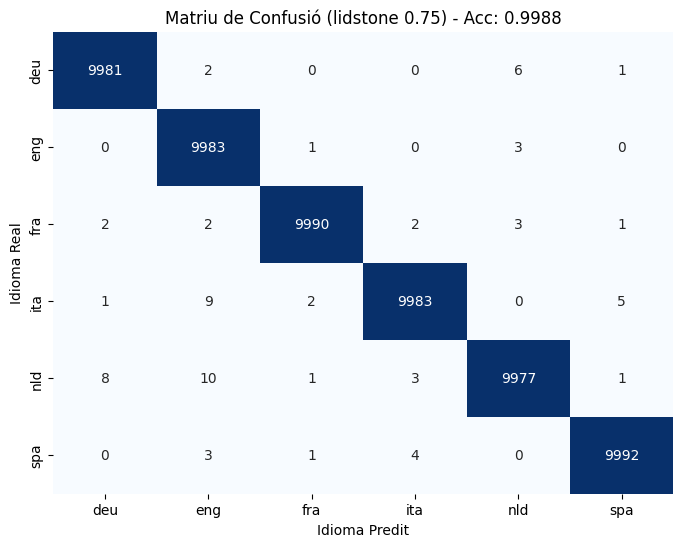


Matriu de Confusió (Text):
      deu   eng   fra   ita   nld   spa
deu  9981     2     0     0     6     1
eng     0  9983     1     0     3     0
fra     2     2  9990     2     3     1
ita     1     9     2  9983     0     5
nld     8    10     1     3  9977     1
spa     0     3     1     4     0  9992


In [ ]:
# Pas 4: Avaluació Final - Construint els models definitius (100% Train)
dades_train_full = {}
dades_test = {}

for idioma in idiomes:
    fitxer_train = f"{idioma}_trn_clean.txt"
    if os.path.exists(fitxer_train):
        with open(fitxer_train, 'r', encoding='utf-8') as f:
            dades_train_full[idioma] = f.read()
            
    fitxer_test = f"{idioma}_tst_clean.txt"
    if os.path.exists(fitxer_test):
        dades_test[idioma] = preprocessor.obtenir_frases_netes(fitxer_test)

model_definitiu = LanguageModel(idiomes)
if dades_train_full:
    model_definitiu.train(dades_train_full)



Avaluant sobre el conjunt de Test (Interpolació 0.8, 0.15, 0.05)...

Resultat Final
Accuracy en Test: 0.9989 (59914/59977 encerts)


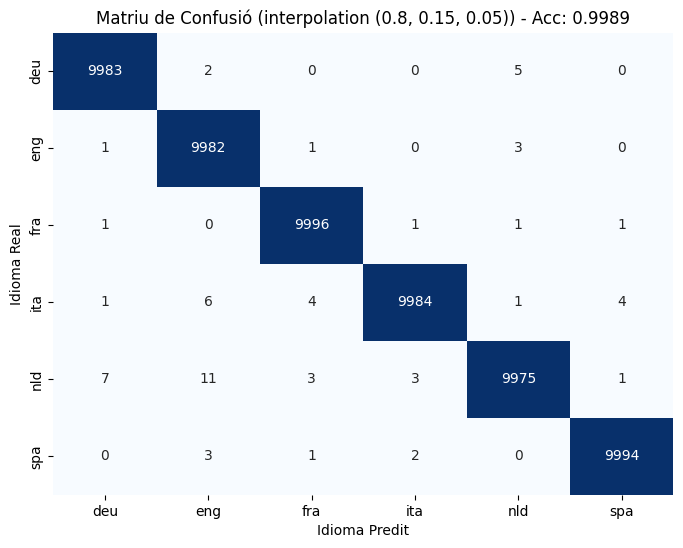


Matriu de Confusió (Text):
      deu   eng   fra   ita   nld   spa
deu  9983     2     0     0     5     0
eng     1  9982     1     0     3     0
fra     1     0  9996     1     1     1
ita     1     6     4  9984     1     4
nld     7    11     3     3  9975     1
spa     0     3     1     2     0  9994


In [ ]:
evaluator = LanguageEvaluator(model_definitiu)

# Avaluant sobre el conjunt de Test (Lidstone 0.75)
if dades_test:
    print("Avaluant sobre el conjunt de Test (Lidstone 0.75)...")
    _, _, _ = evaluator.avaluar_test(dades_test, 'lidstone', 0.75)

# Avaluant sobre el conjunt de Test (Interpolació)
if dades_test:
    print("Avaluant sobre el conjunt de Test (Interpolació 0.8, 0.15, 0.05)...")
    _, _, _ = evaluator.avaluar_test(dades_test, 'interpolation', (0.8, 0.15, 0.05))


### 5.4. Experiment: Impacte del preprocessament amb eliminació de la puntuació

Fins ara, els models principals s'han entrenat conservant tots els signes de puntuació originals del text (només s'han eliminat els dígits). Com a experiment addicional per optimitzar el model, avaluarem l'impacte d'aplicar un **filtratge intel·ligent de la puntuació**. 

Compararem el rendiment del model original amb un de nou on eliminarem la puntuació comuna (punts, comes, parèntesis, guions, etc., que només generen trigrames sorollosos) però **conservarem els signes distintius** que aporten informació morfològica i sintàctica fonamental per a la identificació:
* Els apòstrofs (`'` i `’`): Clau per a les contraccions i elisions en anglès, francès i neerlandès.
* Els signes d'obertura (`¡`, `¿`): Exclusius i altament discriminatoris per al castellà.

A continuació, generem els nous conjunts de dades aplicant aquest filtre mitjançant expressions regulars, entrenem el model alternatiu i l'avaluem sobre el Test Set utilitzant la tècnica guanyadora d'Interpolació Lineal.

Processant deu_trn.txt...
Desat: deu_trn_clean_punct.txt
Processant deu_tst.txt...
Desat: deu_tst_clean_punct.txt
Processant eng_trn.txt...
Desat: eng_trn_clean_punct.txt
Processant eng_tst.txt...
Desat: eng_tst_clean_punct.txt
Processant fra_trn.txt...
Desat: fra_trn_clean_punct.txt
Processant fra_tst.txt...
Desat: fra_tst_clean_punct.txt
Processant ita_trn.txt...
Desat: ita_trn_clean_punct.txt
Processant ita_tst.txt...
Desat: ita_tst_clean_punct.txt
Processant nld_trn.txt...
Desat: nld_trn_clean_punct.txt
Processant nld_tst.txt...
Desat: nld_tst_clean_punct.txt
Processant spa_trn.txt...
Desat: spa_trn_clean_punct.txt
Processant spa_tst.txt...
Desat: spa_tst_clean_punct.txt
Model per 'deu' generat amb èxit. Trigrammes únics: 8156
Model per 'eng' generat amb èxit. Trigrammes únics: 6709
Model per 'fra' generat amb èxit. Trigrammes únics: 7425
Model per 'ita' generat amb èxit. Trigrammes únics: 5795
Model per 'nld' generat amb èxit. Trigrammes únics: 7839
Model per 'spa' generat amb èxi

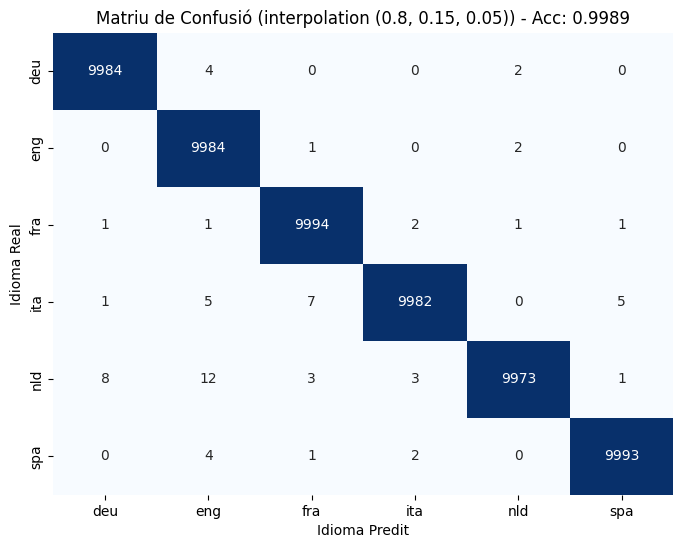


Matriu de Confusió (Text):
      deu   eng   fra   ita   nld   spa
deu  9984     4     0     0     2     0
eng     0  9984     1     0     2     0
fra     1     1  9994     2     1     1
ita     1     5     7  9982     0     5
nld     8    12     3     3  9973     1
spa     0     4     1     2     0  9993


In [10]:
# Executem el preprocessament amb el paràmetre activat
preprocessor_punct = LanguagePreprocessor(idiomes, eliminar_puntuacio=True)
preprocessor_punct.process_files(sufix="_punct") #sufix per no sobreescriure els fitxers originals

dades_train_punct = {}
dades_test_punct = {}

for idioma in idiomes:
    fitxer_train = f"{idioma}_trn_clean_punct.txt"
    if os.path.exists(fitxer_train):
        with open(fitxer_train, 'r', encoding='utf-8') as f:
            dades_train_punct[idioma] = f.read()
            
    fitxer_test = f"{idioma}_tst_clean_punct.txt"
    if os.path.exists(fitxer_test):
        dades_test_punct[idioma] = preprocessor_punct.obtenir_frases_netes(fitxer_test)

# Entrenar el model
model_punct = LanguageModel(idiomes)
if dades_train_punct:
    model_punct.train(dades_train_punct)

# Avaluar amb la tècnica guanyadora (Interpolació 0.8, 0.15, 0.05)
evaluator_punct = LanguageEvaluator(model_punct)

if dades_test_punct:
    _, _, _ = evaluator_punct.avaluar_test(dades_test_punct, 'interpolation', (0.8, 0.15, 0.05))

### 5.5. Conclusions de l'experiment de preprocessament

Els resultats de l'experiment mostren un fenomen contraintuïtiu però molt revelador: el model original, que conserva tota la puntuació, assoleix **59.914 encerts**, mentre que el model amb filtratge intel·ligent obté **59.910 encerts**. L'eliminació de la puntuació ha provocat una lleugera davallada en l'exactitud global, afectant especialment l'italià i el neerlandès.

Aquest resultat demostra que, en els models de trigrames, fins i tot els signes de puntuació suposadament "neutres" (com comes o dos punts) aporten informació estructural valuosa. Cada idioma té la seva pròpia ràtio de longitud de frases, ús de clàusules (fomentant l'aparició de comes) o regles ortotipogràfiques estrictes (com l'espai abans de la puntuació doble en francès). En conseqüència, mantenir el text el més proper possible a la seva naturalesa original maximitza la capacitat del classificador.


## Avaluació Global del Rendiment

In [13]:
#Anàlisi d'errors
# analitzar longitud, idioma i contingut dels documents on falla

errors_trobats = []

for idioma_real, frases in dades_test.items():
    for frase in frases:
        idioma_predit = evaluator.predict(frase, 'interpolation', (0.8, 0.15, 0.05))
        
        if idioma_predit != idioma_real: 
            errors_trobats.append((idioma_real, idioma_predit, frase)) # Si falla, ho guardem a la llista

# --- FUNCIONS PER MOSTRAR EXEMPLES CONCRETS ---

def mostrar_errors_especifics(real_target, predit_target, max_exemples=5):
    print(f"Confusió: {real_target.upper()} real classificat com a {predit_target.upper()}")
    comptador = 0
    for real, predit, frase in errors_trobats:
        if real == real_target and predit == predit_target:
            # Fem un strip() per treure els dobles espais dels extrems a l'hora d'imprimir
            print(f"  -> {frase.strip()}")
            comptador +=1
            if comptador == 5:
                break

    if comptador == 0:
        print("  (Cap error d'aquest tipus)")
    print("-" * 40)

# Imprimim les confusions
mostrar_errors_especifics('deu', 'eng')
mostrar_errors_especifics('deu', 'nld')

mostrar_errors_especifics('eng', 'deu')
mostrar_errors_especifics('eng', 'fra')
mostrar_errors_especifics('eng', 'nld')

mostrar_errors_especifics('fra', 'deu')
mostrar_errors_especifics('fra', 'ita')
mostrar_errors_especifics('fra', 'nld')
mostrar_errors_especifics('fra', 'spa')

mostrar_errors_especifics('ita', 'deu')
mostrar_errors_especifics('ita', 'eng')
mostrar_errors_especifics('ita', 'fra')
mostrar_errors_especifics('ita', 'nld')
mostrar_errors_especifics('ita', 'spa')

mostrar_errors_especifics('nld', 'deu')
mostrar_errors_especifics('nld', 'eng')
mostrar_errors_especifics('nld', 'fra')
mostrar_errors_especifics('nld', 'ita')
mostrar_errors_especifics('nld', 'spa')

mostrar_errors_especifics('spa', 'eng')
mostrar_errors_especifics('spa', 'fra')
mostrar_errors_especifics('spa', 'ita')


Confusió: DEU real classificat com a ENG
  -> jarjarthomas . jan theorethisch ist es simpel.
  -> was ist wicop?
----------------------------------------
Confusió: DEU real classificat com a NLD
  -> blick musiker marc r. († ).
  -> der stoffbeutel war leer.
  -> hij was de leider van de groep in de provincie khorasan van de islamitische staat.
  -> kinder werden von fairplay-liga profitieren.
  -> wat er nu gebeurt, is heel zwaar voor hem als jonge gast.
----------------------------------------
Confusió: ENG real classificat com a DEU
  -> bundesliga: cologne condemn gladbach to derby defeat, bayern crush darmstadt baayen visited darmstadt in a goliath-versus-david clash.
----------------------------------------
Confusió: ENG real classificat com a FRA
  -> internet trouble.
----------------------------------------
Confusió: ENG real classificat com a NLD
  -> follow barrow on twitter at https://www.
  -> in asia, japan's nikkei (.
  -> vancouver head coach willie desjardins.
--------